<a id="contents"></a>

# Risk Score Analysis of COVID-19 Data 
This notebook relates to the exploration of data sets gathered within the USA regarding COVID-19 time-series data from and cause of death data collected from the CDC and collected survey data from client patients.

In this notebook we visualize and analyze time-series based data sets related to cause of death mortality and COVID-19.

### Table of Contents:
* [1. Load Data](#cell1)
* [2. Visualize the Data](#cell2)

<p><img style="float: left; margin:5px 20px 5px 1px; width:40%" src="https://www.nps.gov/aboutus/news/images/CDC-coronavirus-image-23311-for-web.jpg?maxwidth=650&autorotate=false"></p>

In [1]:
## Installing packages needed for data processing and visualization
## pip(optionally) or conda-forge/packages installation on local machine and/or on the cloud (i.e., IBM Watson) 
## A Jupyter notebook extension to hide code and prompts - https://pypi.org/project/hide-code/0.2.0/
# !pip install mysql PyMySQL mysql-connector-python-rf pandas matplotlib seaborn numpy plotly ipywidgets folium appmode voila voila-gridstack voila-vuetify voila-reveal voila-material ibm_db weaviate-client

In [2]:
# Importing the packages
import math
import numpy as np
import pandas as pd
import seaborn as sns
import requests, json
## Database layer interaction
import mysql.connector #This installation was a plague
# import pymysql
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

<a id="cell1"></a> [Back to Contents](#contents)

### 1. Load Data

Read in raw data.

In [3]:
#Cause of Death from CDC from 1962 to 2016
cdc_cod_data = pd.read_csv('https://raw.githubusercontent.com/kenaitian/covid19-model/master/covid-analysis/leading_cause_of_death/good_data/cdc/Deaths_in_122_U.S._cities_-_1962-2016._122_Cities_Mortality_Reporting_System.csv', na_filter= False)

#Cause of Death from NCHS from 1999 to 2017
nchs_cod_data = pd.read_csv('https://raw.githubusercontent.com/kenaitian/covid19-model/master/covid-analysis/leading_cause_of_death/good_data/nchs/NCHS_-_Leading_Causes_of_Death__United_States.csv', na_filter= False)

#Cause of Death from CDC LCD WISQARS from 1999 to 2018
cdc_wisqars_cod_data = pd.read_csv('https://raw.githubusercontent.com/kenaitian/covid19-model/master/covid-analysis/leading_cause_of_death/good_data/cdc/lcd-wisqars.csv', na_filter= False)

#Time series USA COVID-19
request_covid_USA = requests.get('https://covidtracking.com/api/v1/us/daily.json')
covid_USA = request_covid_USA.json()

### 2. Visualize Data as Scatterplots

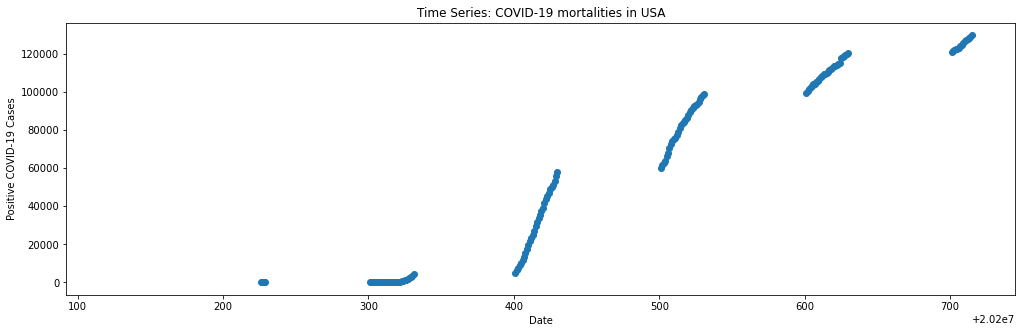

In [4]:
#Dates and Deaths COVID-19 Cases
Dates = []
DeathCases = []
for item in covid_USA:
    Dates.append(item['date'])
    DeathCases.append(item['death'])

plt.rcParams["figure.figsize"]=17,5
plt.scatter(Dates, DeathCases)
plt.xlabel('Date')
plt.ylabel('Positive COVID-19 Cases')
plt.title('Time Series: COVID-19 mortalities in USA')
plt.show()

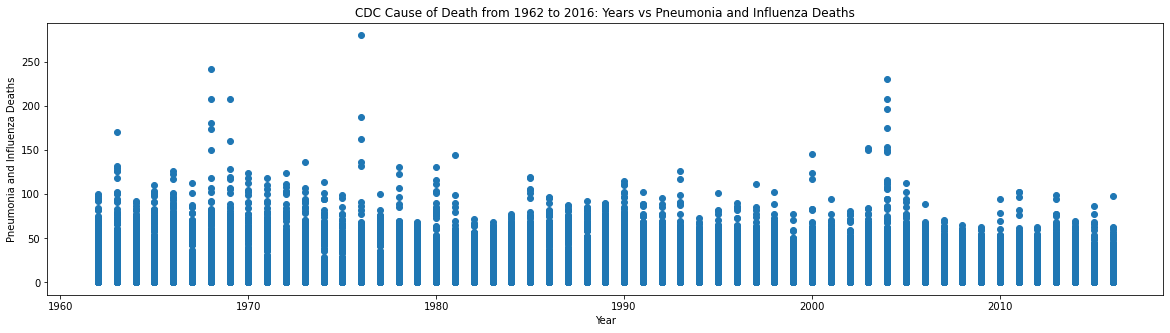

In [5]:
#Cause of death from CDC from 1962 to 2016 flu and pneumonia DEATHS 45-64 y/o
CDC_cod_Dates= []
Deaths_flu_and_pneum = []
for item in cdc_cod_data['Year']:
    if not item:
        continue
    else:
        CDC_cod_Dates.append(item)
for item in cdc_cod_data['Pneumonia and Influenza Deaths']:
    if not item:
        Deaths_flu_and_pneum.append(0)
    else:
        Deaths_flu_and_pneum.append(int(item))

plt.figure(figsize=(20, 5))
plt.scatter(CDC_cod_Dates, Deaths_flu_and_pneum)
plt.xlabel('Year')
plt.ylabel('Pneumonia and Influenza Deaths')
plt.title('CDC Cause of Death from 1962 to 2016: Years vs Pneumonia and Influenza Deaths')
plt.show()

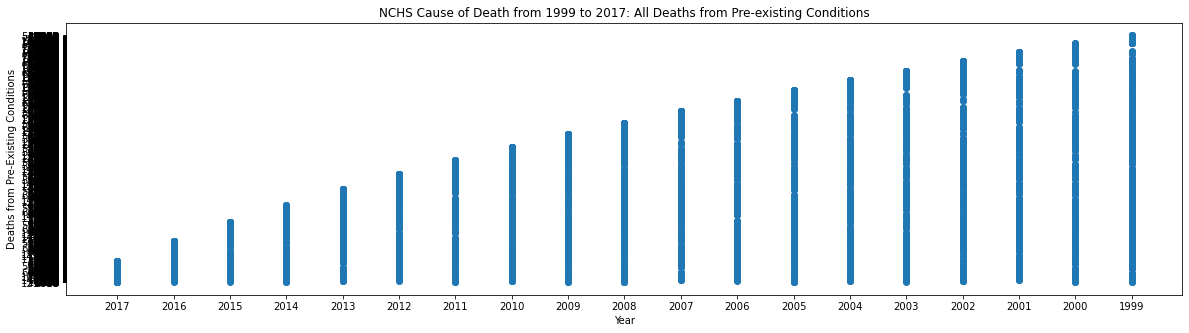

In [6]:
#Cause of death from NCHS from 1999 to 2017
NCHS_cod_Dates = []
Deaths_nchs = []
for item in nchs_cod_data['Year']:
    if not item:
        continue
    else:
        NCHS_cod_Dates.append(item)
for item in nchs_cod_data['Deaths']:
    if not item:
        continue
    else:
        Deaths_nchs.append(item)

fixed_nchs_dates = NCHS_cod_Dates.copy()
fixed_nchs_deaths = Deaths_nchs.copy()
fixed_nchs_dates.reverse()
fixed_nchs_deaths.reverse()

plt.figure(figsize=(20, 5))
plt.scatter(NCHS_cod_Dates, Deaths_nchs)
plt.xlabel('Year')
plt.ylabel('Deaths from Pre-Existing Conditions')
plt.title('NCHS Cause of Death from 1999 to 2017: All Deaths from Pre-existing Conditions')
plt.show()

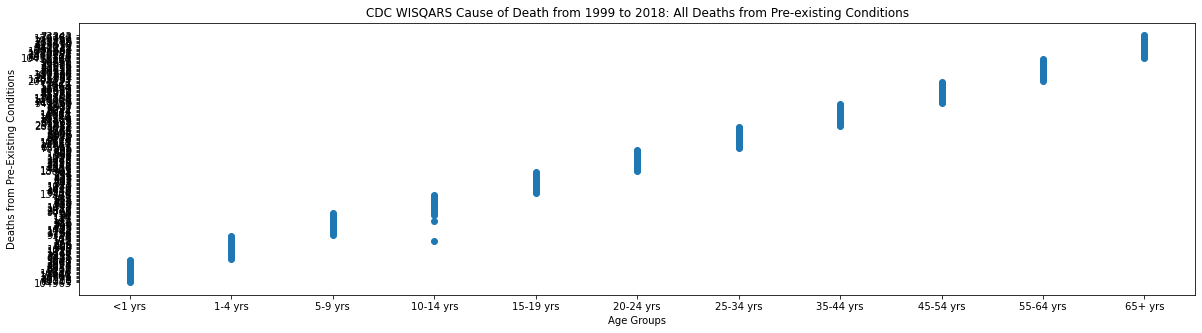

In [7]:
#Cause of death from CDC LCD WISQARS from 1999 to 2018
cdc_wisqars_ages = []
cdc_wisqars_deaths = []
for item in cdc_wisqars_cod_data['Age Group']:
    if not item:
        continue
    else:
        cdc_wisqars_ages.append(item)
for item in cdc_wisqars_cod_data['Deaths']:
    if not item:
        continue
    else:
        cdc_wisqars_deaths.append(item)

plt.figure(figsize=(20, 5))
plt.scatter(cdc_wisqars_ages, cdc_wisqars_deaths)
plt.xlabel('Age Groups')
plt.ylabel('Deaths from Pre-Existing Conditions')
plt.title('CDC WISQARS Cause of Death from 1999 to 2018: All Deaths from Pre-existing Conditions')
plt.show()

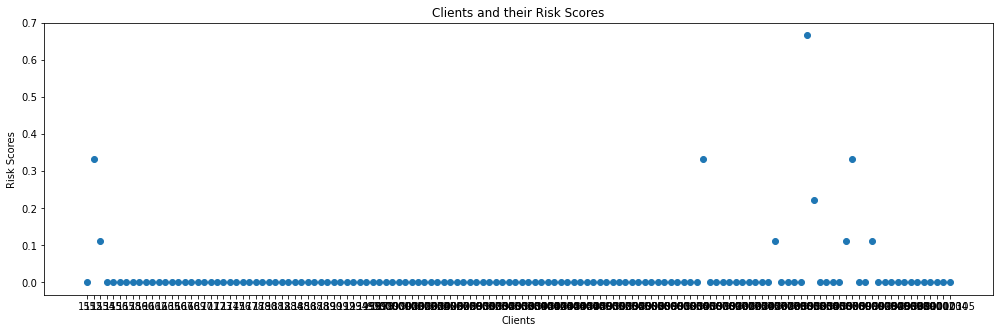

In [8]:
mydb = mysql.connector.connect(
  user="wcadmin",
  host="mysql-code2020-db1.cngsuwoginmf.us-east-1.rds.amazonaws.com",
  passwd="Mycaresec1",
  database='wcadb1'
)

#Set a cursor for querying
cursor = mydb.cursor()

#Use a list of conditions and risks to match against the client patient
conditions_risks = ["Diabetes", "Congestive Heart Failure", "Asthma", "COPD", "Heart Disease", "Cancer", "Smoke", "HIV", "Breathing Difficulty"]

#Fetch ClientIDs

query = (
    "SELECT ClientID FROM ClientPatient"
)

cursor.execute(query)
results = list(cursor.fetchall())
result_conv = str(results)
import re
result_conv_cleaned = re.findall(r"\d+", result_conv)
client_ids = result_conv_cleaned
#print(client_ids)

risk_ids = []
risk_scores = []
for client_id in client_ids:
    #Use ClientID to find pre-existing conditions and risks
    query_pre_existing = (
        """SELECT MedHistory, MedHistory2, DxAllergyReact FROM ClientMedicalHistory 
           WHERE ClientID = '"""+client_id+"""' 
                 AND PharmacyCard_MI != 'Test' AND PharmacyCard_MI != 'Test1' AND PharmacyCard_FN != ''
                 AND PharmacyCard_MI != ''"""
    )
    cursor.execute(query_pre_existing)
    results_pre_existing = cursor.fetchall()
    results_pre_existing_conv = str(results_pre_existing)
    #print(results_pre_existing_conv)

    #Split the dirty string of collected pre-existing conditions and risks from client patient
    results_pre_existing_list_dirty = results_pre_existing_conv.split('|')
    #print(results_pre_existing_list_dirty)

    #Clean the dirty string of pre-existing conditions and risks
    results_pre_existing_list_cleaned = []
    for condition in results_pre_existing_list_dirty:
        if any(risk in condition for risk in conditions_risks):
            results_pre_existing_list_cleaned.append(condition)
    #print(results_pre_existing_list_cleaned)

    #Calculate raw risk score
    risk_score = len(results_pre_existing_list_cleaned)/len(conditions_risks)
    #print(risk_score)
    
    risk_scores.append(risk_score)
#print(risk_scores)

plt.rcParams["figure.figsize"]=17,5
plt.scatter(client_ids, risk_scores)
plt.xlabel('Clients')
plt.ylabel('Risk Scores')
plt.title('Clients and their Risk Scores')
plt.show()

#Close DB connection
# cursor.close()
# mydb.close()

In [9]:
# display(HTML('<h2>More Info on COVID-19:<a href="#More-Info-on-COVID-19:"></h2>'
# '<ul>'
#              '<li><a href="https://www.who.int/health-topics/coronavirus">https://www.who.int/health-topics/coronavirus</a></li>'
#              '<li><a href="https://www.who.int/emergencies/diseases/novel-coronavirus-2019">https://www.who.int/emergencies/diseases/novel-coronavirus-2019</a></li>'
#              '<li><a href="https://www.nature.com/articles/s41597-020-0448-0">https://www.nature.com/articles/s41597-020-0448-0</a></li>'
# '</ul>'))